### __Imports and installs__

In [1]:
from pathlib import Path
import subprocess
from tqdm import tqdm
import os

import torch
from torch.utils.data import DataLoader

from utils_dataset import CustomImageDataset, deprocess_image, load_labels
from utils_plot import show_images, show_one_image, show_cams, show_one_cam, show_centers
from utils_cam import generate_cams
from utils_models import load_model, evaluate_model_accuracy
from utils_adversarial import APD, save_adversarial_images



In [2]:
batch_size = 24
num_workers = 4

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### __Dataset__

In [3]:
squeezenet = load_model("squeezenet")
resnet101 = load_model("resnet101")
inception_v3 = load_model("inception_v3")
inception_v4 = load_model("inception_v4")
adv_inception_v3 = load_model("adv_inception_v3")
inception_resnet_v2 = load_model("inception_resnet_v2")

models = [squeezenet, resnet101, inception_v3, inception_v4, adv_inception_v3, inception_resnet_v2]

Loading model 'squeezenet' from Model/squeezenet.pth
Loading model 'resnet101' from Model/resnet101.pth
Loading model 'inception_v3' from Model/inception_v3.pth
Loading model 'inception_v4' from Model/inception_v4.pth
Loading model 'adv_inception_v3' from Model/adv_inception_v3.pth
Loading model 'inception_resnet_v2' from Model/inception_resnet_v2.pth


In [4]:
images_folder_path = Path('tf_to_pytorch_model/dataset/images')
label_file_path = Path('tf_to_pytorch_model/dataset/dev_dataset.csv')

# Check if the images folder exists; if not, clone the repository
if not images_folder_path.exists():
    repo_url = 'https://github.com/ylhz/tf_to_pytorch_model.git'
    try:
        subprocess.run(["git", "clone", repo_url], check=True)
        print(f"Repository cloned successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone repository: {e}")


In [5]:
labels_dict = load_labels()

dataset = CustomImageDataset(label_file_path, images_folder_path)

dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)


Loading labels from imagenet_class_index.json


In [6]:
# for model in models:
#     evaluate_model_accuracy(model, dataloader, device)

### __Class Activation Maps__

In [7]:
# Show some images from the dataset

data_iter = iter(dataloader)
images, labels, _ = next(data_iter)

# show_images(images, labels, labels_dict, rows=2)

Processing CAMs for squeezenet: 100%|██████████| 12/12 [00:00<00:00, 299.72it/s]


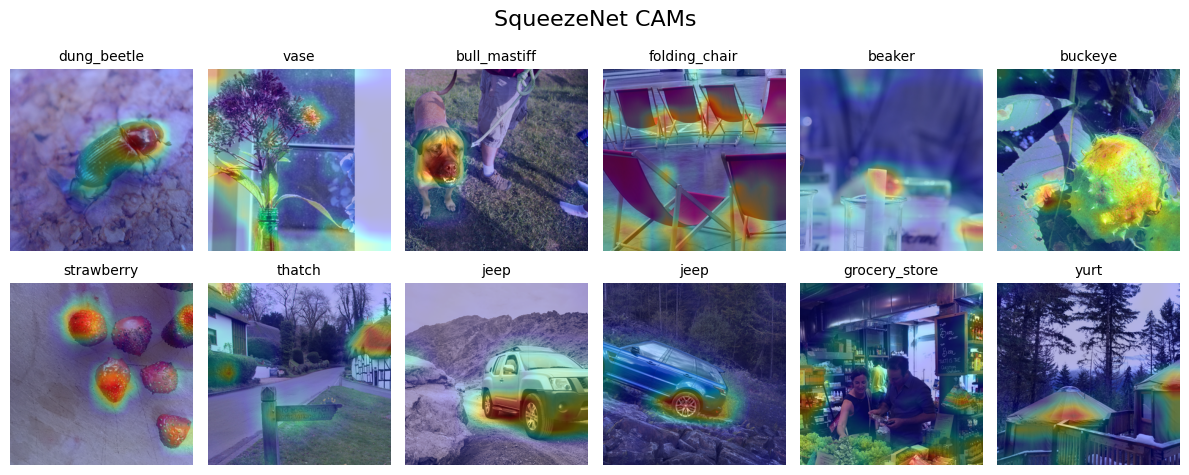

Processing CAMs for resnet101: 100%|██████████| 12/12 [00:00<00:00, 254.90it/s]


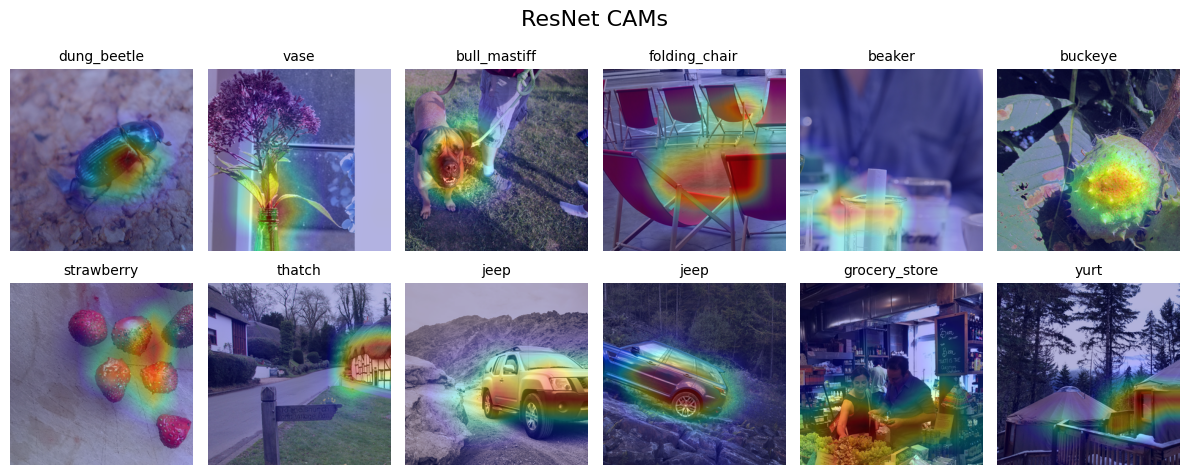

Processing CAMs for inception_v3: 100%|██████████| 12/12 [00:00<00:00, 259.10it/s]


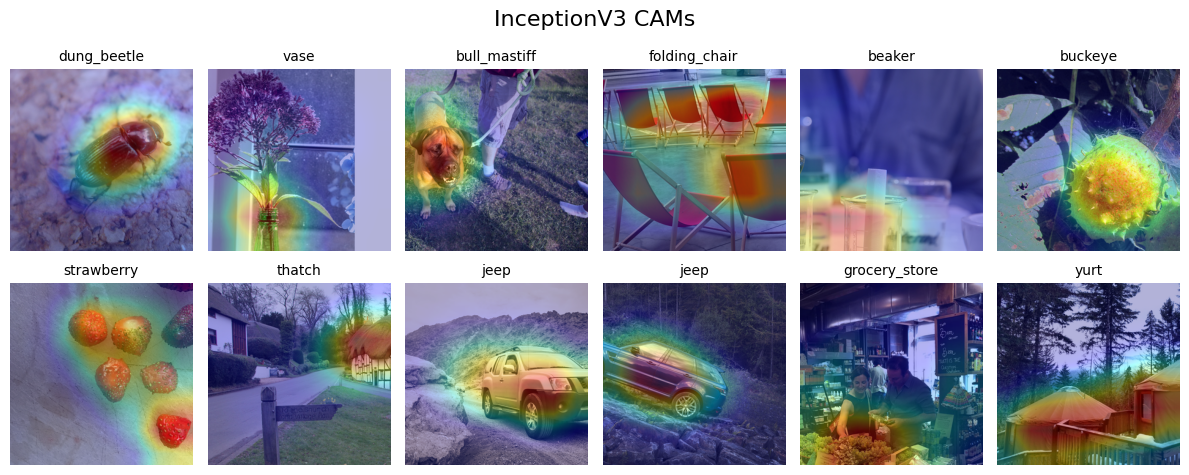

Processing CAMs for inception_v4: 100%|██████████| 12/12 [00:00<00:00, 234.27it/s]


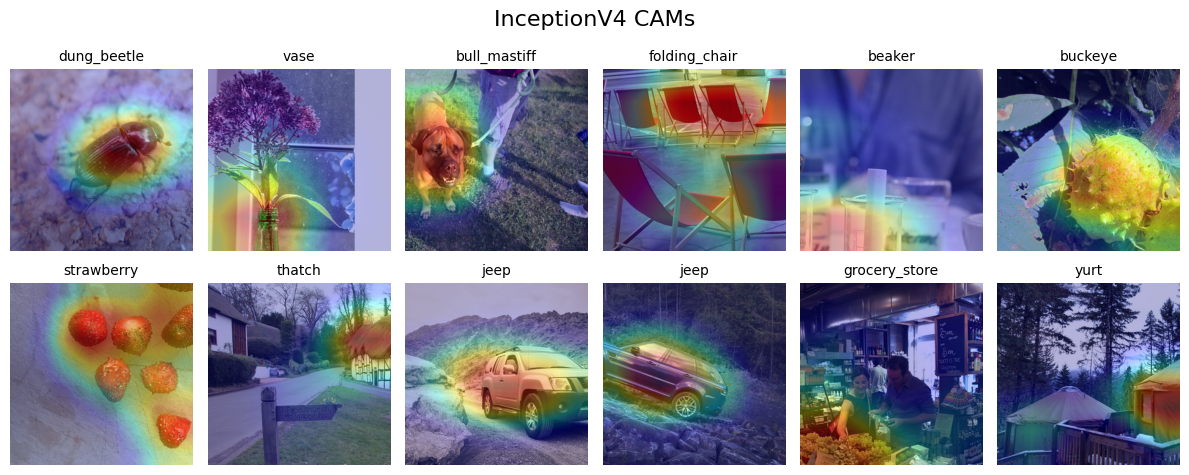

Processing CAMs for adv_inception_v3: 100%|██████████| 12/12 [00:00<00:00, 254.74it/s]


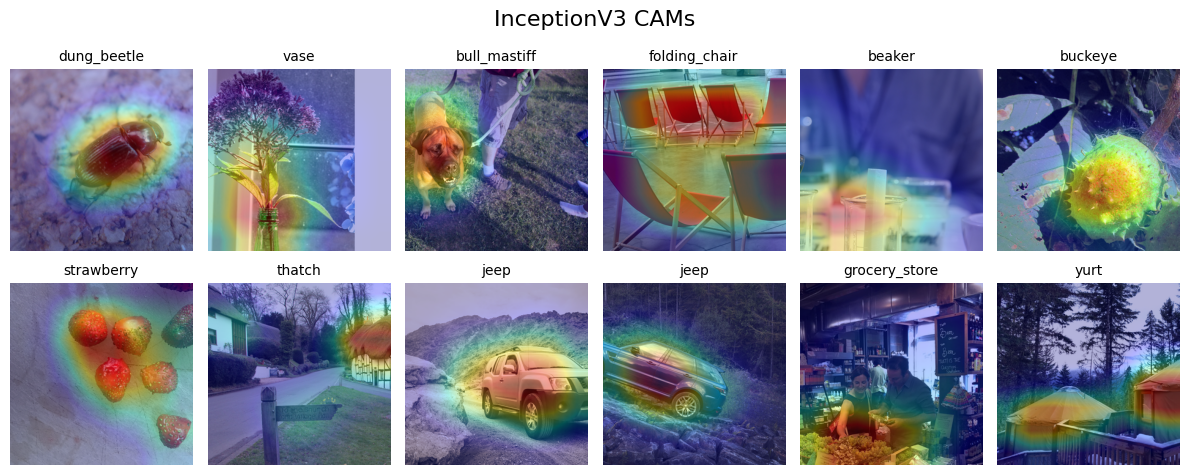

Processing CAMs for inception_resnet_v2: 100%|██████████| 12/12 [00:00<00:00, 237.48it/s]


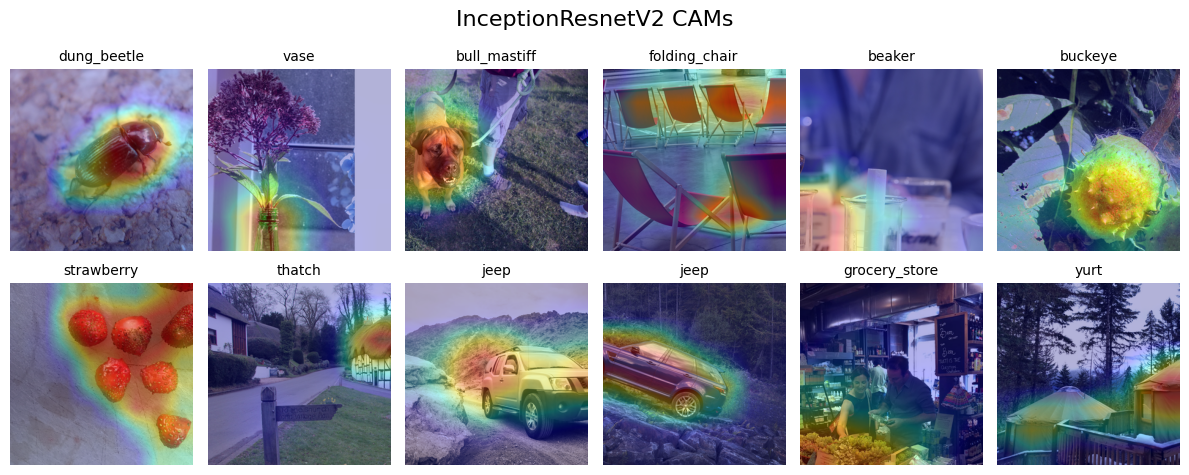

In [8]:
# Show grad cams for some images for each model

# for model in models:
#     model.to(device)
#     show_cams(model, images, labels, labels_dict, rows=2, image_weight=0.7)
#     model.to('cpu')


In [9]:
# idx = 17
# for model in models:
#     print(model.name)
#     show_one_cam(model, images[idx], labels[idx], image_weight=0.7)

# show_one_image(images[idx])

### __Local Maxima__

In [10]:
images, labels, _ = next(iter(dataloader))

# for model in models:
#     show_centers(model, images, labels)

### __Main algorithm__

#### Example use

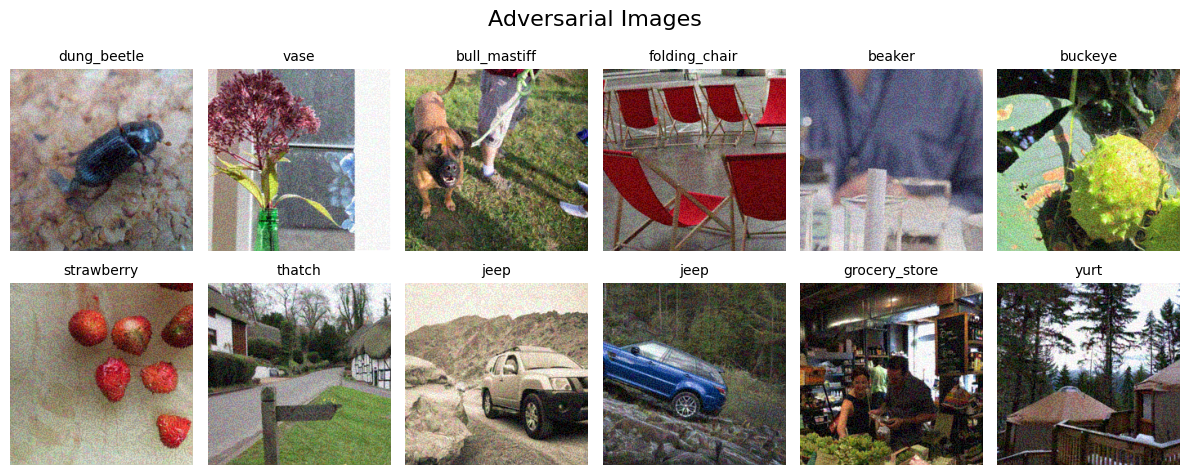

In [11]:
images, labels, _ = next(iter(dataloader))
model = squeezenet

model.to(device)
x_adv = APD(images, labels, model)
model.to('cpu')

x_adv_dep = deprocess_image(x_adv)

show_images(x_adv_dep, labels, labels_dict, title="Adversarial Images")

In [12]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_apd")

Directory 'Generated/squeezenet_adv' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/resnet101_adv' already exists. Skipping adversarial image generation and saving.


Generating adversarial images with inception_v3: 100%|██████████| 42/42 [09:42<00:00, 13.86s/it]


Adversarial images saved in 'Generated/inception_v3_adv'.


Generating adversarial images with inception_v4:  17%|█▋        | 7/42 [02:53<14:27, 24.77s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1374058/1606734499.py", line 2, in <module>
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_adv")
  File "/users/nfs/Etu8/17009018/APD_AMAL/utils_adversarial.py", line 267, in save_adversarial_images
  File "/users/nfs/Etu8/17009018/APD_AMAL/utils_adversarial.py", line 201, in APD
    grad.data = replace_pixels(grad.data, torch.zeros_like(grad.data), center, "threshold", grayscale_cam[0],
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwa

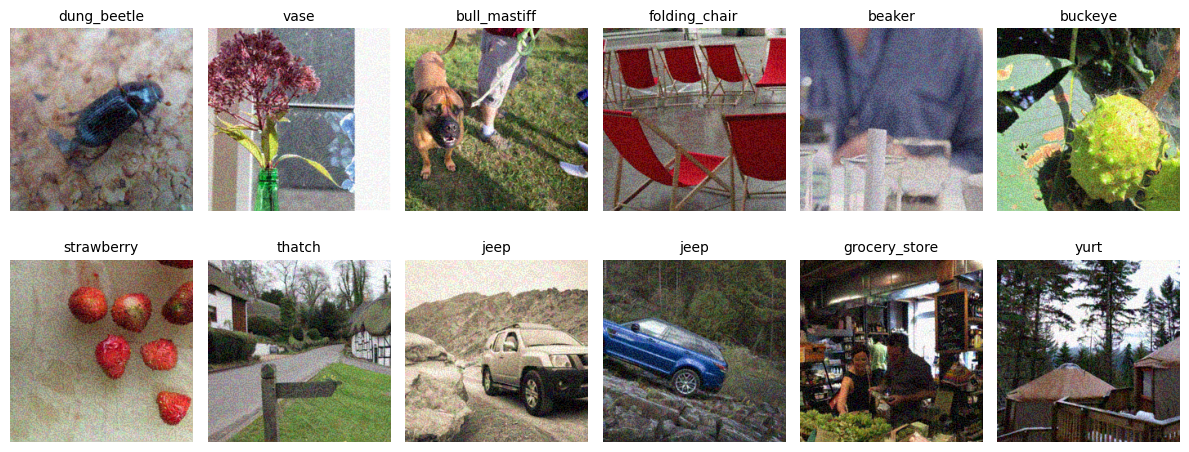

Attacking squeezenet with squeezenet


Evaluating: 100%|██████████| 42/42 [00:01<00:00, 24.05it/s]


Accuracy of squeezenet: 0.0%
Attacking resnet101 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:04<00:00,  9.11it/s]


Accuracy of resnet101: 87.3%
Attacking inception_v3 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:04<00:00, 10.01it/s]


Accuracy of inception_v3: 71.5%
Attacking inception_v4 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:06<00:00,  6.28it/s]


Accuracy of inception_v4: 66.1%
Attacking adv_inception_v3 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:04<00:00, 10.15it/s]


Accuracy of adv_inception_v3: 66.8%
Attacking inception_resnet_v2 with squeezenet


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.46it/s]


Accuracy of inception_resnet_v2: 74.1%


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/users/nfs/Etu8/17009018/APD_AMAL/utils_dataset.py", line 48, in __getitem__
    image = read_image(img_path)  # Load the image tensor
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torchvision/io/image.py", line 258, in read_image
    data = read_file(path)
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torchvision/io/image.py", line 52, in read_file
    data = torch.ops.image.read_file(path)
  File "/users/Etu8/17009018/venv/myenv/lib/python3.9/site-packages/torch/_ops.py", line 755, in __call__
    return self._op(*args, **(kwargs or {}))
RuntimeError: [Errno 2] No such file or directory: 'Generated/resnet101_adv/0c7ac4a8c9dfa802.png'


In [16]:
for model in models:
    images_folder_path = os.path.join("Generated", f"{model.name}_adv")
    dataset = CustomImageDataset(label_file_path, images_folder_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    data_iter = iter(dataloader)
    images, labels, _ = next(data_iter)
    show_images(images, labels, labels_dict, rows=2)
    for model_target in models:
        print(f"Attacking {model_target.name} with {model.name}")
        evaluate_model_accuracy(model_target, dataloader, device)



In [ ]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_mfgsm_adv", attack_method="MFGSM")

TODO : clamp avec bonnes valeurs et adapter eps en conséquence (done!);, Essayer moyenner x_adv sur différents modèles !!
IDEES AMELIO : rescale dans algo (done), gradCAM (RDFIA) en + de gradCAM++ (done); threshold au lieu de région carrée pour régions dropout (done), tester en mettant le gradient à 0 dans les régions dropped out (done)